In [1]:
#Capstone III
#Preprocessing and Modelling 
#Ofri Oren

In [15]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Show plots inline
%matplotlib inline

import datetime as dt
import os
import io 

#!pip install opencv-python
#!pip install tensorflow


#Import neural network tools
#!pip install keras tensorflow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,  MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

# Import the necessary modules from scikit-image for image transformation, and exposure adjustment
from skimage.transform import resize, rotate 
from skimage.exposure import equalize_adapthist

#Image imports
import imageio.v3 as imageio
from scipy import ndimage as ndi
from skimage import filters, exposure, transform, morphology, restoration, util, segmentation, measure, feature
from PIL import Image
from skimage.draw import polygon
from matplotlib.patches import Polygon


Loaded image volume shape: (102, 640, 640, 3)


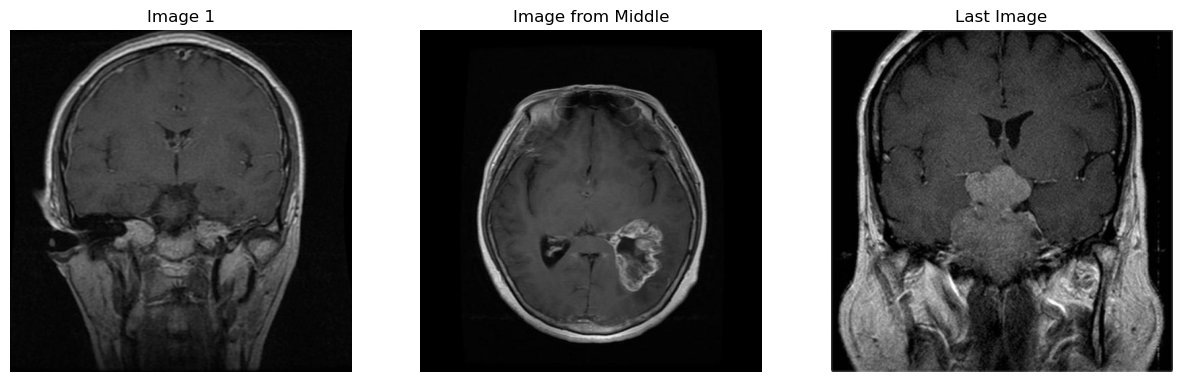

In [59]:
# Path to the folder containing the images
folder_path_images = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/images"

# Initialize a list to store image data
volume_train_images = []

# Iterate through the files in the folder
for filename in sorted(os.listdir(folder_path_images)):  # Sort to maintain order
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Check for valid image files
        filepath_image = os.path.join(folder_path_images, filename)
        try:
            # Open the image using PIL
            img = Image.open(filepath_image).convert('RGB')  # Ensure all images are RGB
            img_array = np.array(img)  # Convert the image to a NumPy array
            volume_train_images.append(img_array)  # Append the image to the list
        except Exception as e:
            print(f"Error loading image {filepath_image}: {e}")

# Convert the list of images into a NumPy array (volume)
try:
    volume_train_images = np.stack(volume_train_images)
    print(f"Loaded image volume shape: {volume_train_images.shape}")  # Expected shape: (number_of_images, height, width, channels)
except ValueError as e:
    print(f"Error stacking images into volume: {e}")

# Display a few images to confirm successful loading
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
if len(volume_train_images) >= 3:
    axes[0].imshow(volume_train_images[0])
    axes[0].set_title('Image 1')
    axes[1].imshow(volume_train_images[len(volume_train_images) // 2])
    axes[1].set_title('Image from Middle')
    axes[2].imshow(volume_train_images[-1])
    axes[2].set_title('Last Image')
    for ax in axes:
        ax.axis('off')
    plt.show()
else:
    print("Not enough images to display.")

Displaying meningioma47_jpg.rf.ef504a28fd196407fa72365c6c69e93c.jpg with polygons


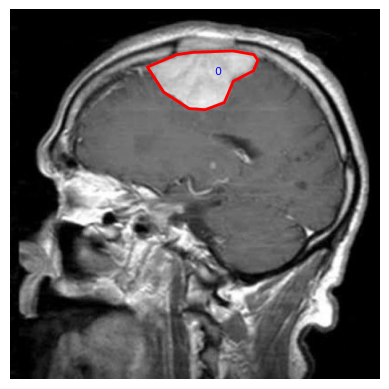

In [60]:
#I have to open the label data which appears to have information about a polygon around the tumor.
def load_polygon_from_file(file_path):
    """Parse a label file to extract polygon points and labels."""
    with open(file_path, 'r') as f:
        lines = f.readlines()
        polygon_points = []
        labels = []
        for line in lines:
            values = line.strip().split(' ')
            coords = list(map(float, values[1:]))
            points = [(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)]
            polygon_points.append(points)
            labels.append(values[0])  # Assuming first value is the label
    return polygon_points, labels


def scale_polygons_to_image(polygons, img_width, img_height):
    """Scale polygons to the image dimensions."""
    scaled_polygons = []
    for poly in polygons:
        scaled_poly = [(x * img_width, y * img_height) for x, y in poly]
        scaled_polygons.append(scaled_poly)
    return scaled_polygons


def plot_polygon_on_image(image_path, polygons, labels=None):
    """Plot polygons on an image."""
    img = Image.open(image_path)
    img_width, img_height = img.size
    plt.imshow(img)
    for i, points in enumerate(polygons):
        polygon = Polygon(points, edgecolor='r', fill=None, linewidth=2)
        plt.gca().add_patch(polygon)
        if labels:
            centroid = np.mean(points, axis=0)
            plt.text(centroid[0], centroid[1], labels[i], color='blue', fontsize=8)
    plt.axis('off')
    plt.show()


# Paths
labels_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/labels"
images_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/images"

# Iterate through label files
for label_file in os.listdir(labels_folder):
    if label_file.endswith('.txt'):
        # Load polygons and labels
        label_path = os.path.join(labels_folder, label_file)
        polygons, labels = load_polygon_from_file(label_path)
        
        # Find the corresponding image file
        image_file = label_file.replace('.txt', '.jpg')  # Adjust extension as needed
        image_path = os.path.join(images_folder, image_file)
        
        if os.path.exists(image_path):
            # Load image dimensions
            img = Image.open(image_path)
            img_width, img_height = img.size
            
            # Scale polygons to match image dimensions
            scaled_polygons = scale_polygons_to_image(polygons, img_width, img_height)
            
            # Plot polygons on the image
            print(f"Displaying {image_file} with polygons")
            plot_polygon_on_image(image_path, scaled_polygons, labels)
            break  # Display only the first image for examination
        else:
            print(f"Image not found for label file: {label_file}")

In [63]:
import os
import numpy as np
from PIL import Image, ImageDraw
import tensorflow as tf

# Paths
labels_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/labels"
images_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/images"

# Initialize arrays for images and masks
volume_images = []
volume_masks = []

def create_mask_from_polygons(polygons, img_width, img_height):
    """Create a binary mask from polygon coordinates."""
    mask = Image.new('L', (img_width, img_height), 0)  # Create a blank black image
    draw = ImageDraw.Draw(mask)
    for polygon in polygons:
        draw.polygon(polygon, outline=1, fill=1)  # Draw polygons on the mask
    return np.array(mask)

# Iterate through label files
for label_file in sorted(os.listdir(labels_folder)):
    if label_file.endswith('.txt'):  # Check for label files
        # Load polygons and labels
        label_path = os.path.join(labels_folder, label_file)
        polygons, _ = load_polygon_from_file(label_path)
        
        # Find the corresponding image file
        image_file = label_file.replace('.txt', '.jpg')  # Adjust extension as needed
        image_path = os.path.join(images_folder, image_file)
        
        if os.path.exists(image_path):
            # Load the image
            img = Image.open(image_path)
            img_width, img_height = img.size
            img_array = np.array(img)
            
            # Create a mask from the polygons
            mask_array = create_mask_from_polygons(polygons, img_width, img_height)
            
            # Add image and mask to volumes
            volume_images.append(img_array)
            volume_masks.append(mask_array)
        else:
            print(f"Image not found for label file: {label_file}")

# Convert to NumPy arrays
volume_images = np.stack(volume_images)  # Shape: (num_images, height, width, channels)
volume_masks = np.stack(volume_masks)    # Shape: (num_images, height, width)

# Normalize images and masks
volume_images = volume_images / 255.0  # Scale images to [0, 1]
volume_masks = volume_masks.astype('float32')  # Ensure masks are float32

print(f"Image volume shape: {volume_images.shape}")
print(f"Mask volume shape: {volume_masks.shape}")

print("Training dataset prepared.")


Image volume shape: (102, 640, 640, 3)
Mask volume shape: (102, 640, 640)
Training dataset prepared.


In [6]:
#modelling

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

def unet_model(input_shape=(640, 640, 3), num_classes=2):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c5)
    
    model = Model(inputs, outputs)
    return model

# Create the model
model = unet_model(input_shape=(640, 640, 3), num_classes=2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 640, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 640, 640,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 640, 640,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 320, 320,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 320, 320,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 320, 320,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 160, 160,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 160, 160,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 160, 160,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 320, 320,  │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 320, 320,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 320, 320,  │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 320, 320,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 640, 640,  │      8,224 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 640, 640,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 640, 640,  │     18,464 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 640, 640,  │      9,248 │ conv2d_8[0][0]  

 Total params: 466,562 (1.78 MB)

 Trainable params: 466,562 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#Renaming the volumes
train_data = volume_images
train_masks = volume_masks

#Compiling the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Ensure your masks are integers representing class indices
train_masks = train_masks.astype('int32')

# Train the model
training = model.fit(train_data, train_masks, epochs=3, validation_split=0.2)

Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1998s 713s/step - accuracy: 0.9735 - loss: 0.6434 - val_accuracy: 1.0000 - val_loss: 0.4353
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 706s 187s/step - accuracy: 1.0000 - loss: 0.4055 - val_accuracy: 1.0000 - val_loss: 0.0566
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1442s 552s/step - accuracy: 1.0000 - loss: 0.0582 - val_accuracy: 1.0000 - val_loss: 2.1874e-05


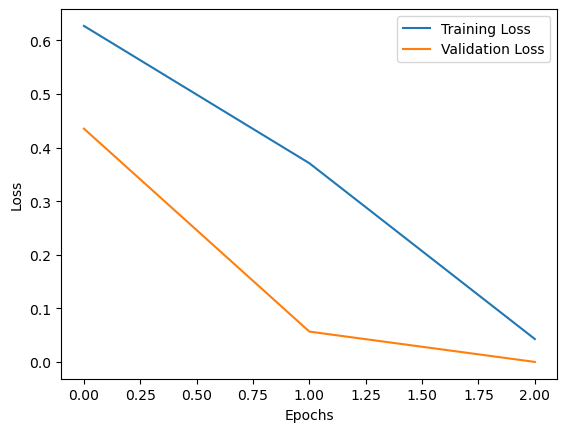

In [8]:
#Generating a checkpoint and saving the node weights
checkpoint = ModelCheckpoint('weights.keras', monitor='val_loss', save_best_only=True)
callbacks = [checkpoint]
print(callbacks)

# Plot the loss and validation loss
plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')

# Add axis labels
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to distinguish the lines
plt.legend()

# Display the plot
plt.show()


In [9]:
#Now let's see how the model performs on the test data and whether I need to adjust training data.

Loaded volume shape: (15, 640, 640, 3)


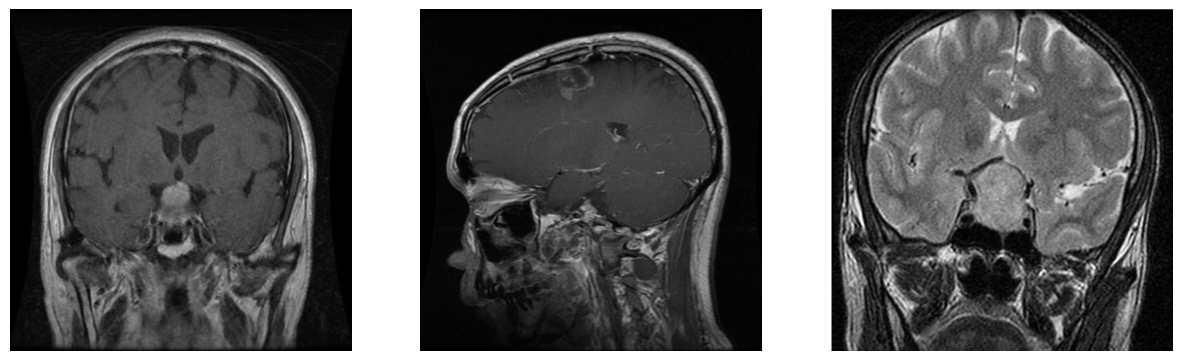

In [45]:
#I have all of the images stored with their labels in a dictionary, but for batch processing and viewing I will create 
# a volume.

folder_path = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/test/images"

# Load all images in the folder as a volume
volume = []

for filename in sorted(os.listdir(folder_path)):  # Sort to maintain order
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        filepath = os.path.join(folder_path, filename)
        try:
            # Open the image with Pillow
            img = Image.open(filepath)
            # Convert to a NumPy array and append to the volume
            volume.append(np.array(img))
        except Exception as e:
            print(f"Error loading image {filepath}: {e}")

# Convert the volume list to a 3D NumPy array
volume = np.stack(volume)

print(f"Loaded volume shape: {volume.shape}")  # (Number of images, height, width)

# Display a few slices from the volume
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(volume[0], cmap='gray')
axes[1].imshow(volume[len(volume) // 2], cmap='gray')
axes[2].imshow(volume[-1], cmap='gray')
for ax in axes:
    ax.axis('off')
plt.show()

In [65]:

# Paths
labels_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/test/labels"
images_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/test/images"

# Initialize arrays for images and masks
volume_test_images = []
volume_test_masks = []


# Iterate through label files
for label_file in sorted(os.listdir(labels_folder)):
    if label_file.endswith('.txt'):  # Check for label files
        # Load polygons and labels
        label_path = os.path.join(labels_folder, label_file)
        polygons, _ = load_polygon_from_file(label_path)
        
        # Find the corresponding image file
        image_file = label_file.replace('.txt', '.jpg')  # Adjust extension as needed
        image_path = os.path.join(images_folder, image_file)
        
        if os.path.exists(image_path):
            # Load the image
            img = Image.open(image_path)
            img_width, img_height = img.size
            img_array = np.array(img)
            
            # Create a mask from the polygons
            mask_array = create_mask_from_polygons(polygons, img_width, img_height)
            
            # Add image and mask to volumes
            volume_test_images.append(img_array)
            volume_test_masks.append(mask_array)
        else:
            print(f"Image not found for label file: {label_file}")

# Convert to NumPy arrays
volume_test_images = np.stack(volume_test_images)  # Shape: (num_images, height, width, channels)
volume_test_masks = np.stack(volume_test_masks)    # Shape: (num_images, height, width)

# Normalize images and masks
volume_test_images = volume_test_images / 255.0  # Scale images to [0, 1]
volume_test_masks = volume_test_masks.astype('float32')  # Ensure masks are float32

print(f"Image test volume shape: {volume_test_images.shape}")
print(f"Mask test volume shape: {volume_test_masks.shape}")

print("Test dataset prepared.")


Image test volume shape: (15, 640, 640, 3)
Mask test volume shape: (15, 640, 640)
Test dataset prepared.


Shape of test_data: (15, 640, 640, 3)
Shape of test_masks: (15, 640, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Shape of predictions: (15, 640, 640, 2)
Shape of predicted masks: (15, 640, 640)


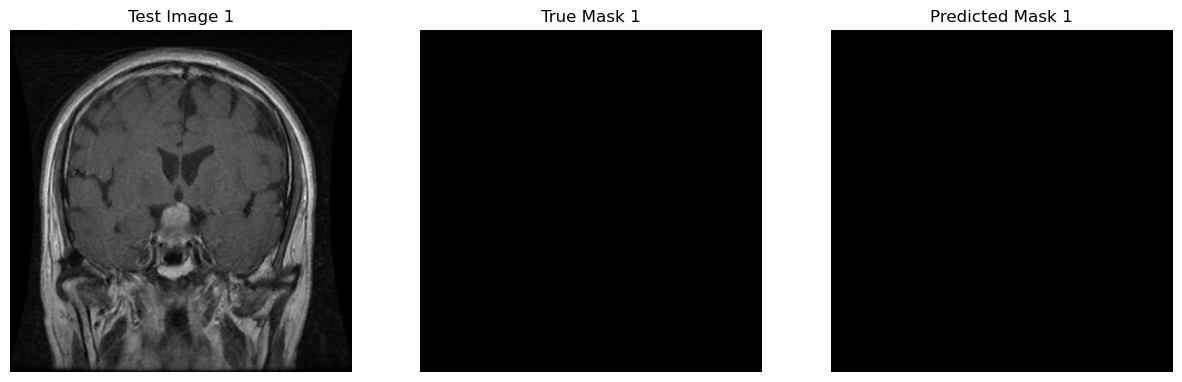

In [71]:
# Renaming the volumes
test_data = volume_test_images  # The images to predict on
test_masks = volume_test_masks  # The true masks for comparison

# Check the shape of both
print(f"Shape of test_data: {test_data.shape}")
print(f"Shape of test_masks: {test_masks.shape}")

# Predict the output for test data (segmentation)
predictions = model.predict(test_data)

# Check the shape of the predictions
print(f"Shape of predictions: {predictions.shape}")

# Predictions will have shape (num_samples, height, width, num_classes)
# Convert predictions to the class with the highest probability for each pixel
predicted_masks = np.argmax(predictions, axis=-1)  # Choose the class with the highest probability per pixel

# Check the shape of predicted masks
print(f"Shape of predicted masks: {predicted_masks.shape}")

# Now, predicted_masks will be the predicted class labels for each pixel in each image
# The shape will be (num_samples, height, width), with each pixel in the mask showing the class id

# Example of how to compare a few predicted masks to the ground truth
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the first image and its true mask and predicted mask
axes[0].imshow(test_data[0])
axes[0].set_title('Test Image 1')
axes[1].imshow(test_masks[0], cmap='gray')
axes[1].set_title('True Mask 1')
axes[2].imshow(predicted_masks[0], cmap='gray')
axes[2].set_title('Predicted Mask 1')

for ax in axes:
    ax.axis('off')

plt.show()

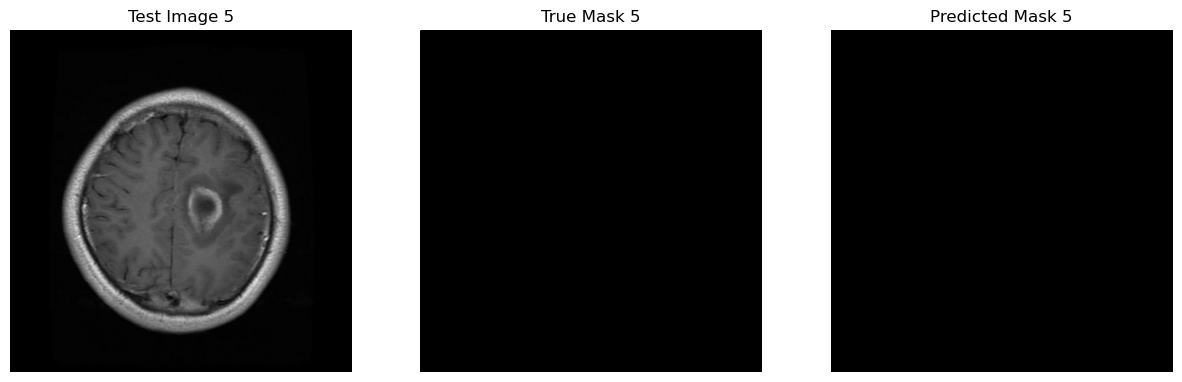

In [73]:
# Example of how to compare a few predicted masks to the ground truth
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the first image and its true mask and predicted mask
axes[0].imshow(test_data[4])
axes[0].set_title('Test Image 5')
axes[1].imshow(test_masks[4], cmap='gray')
axes[1].set_title('True Mask 5')
axes[2].imshow(predicted_masks[4], cmap='gray')
axes[2].set_title('Predicted Mask 5')

for ax in axes:
    ax.axis('off')

plt.show()

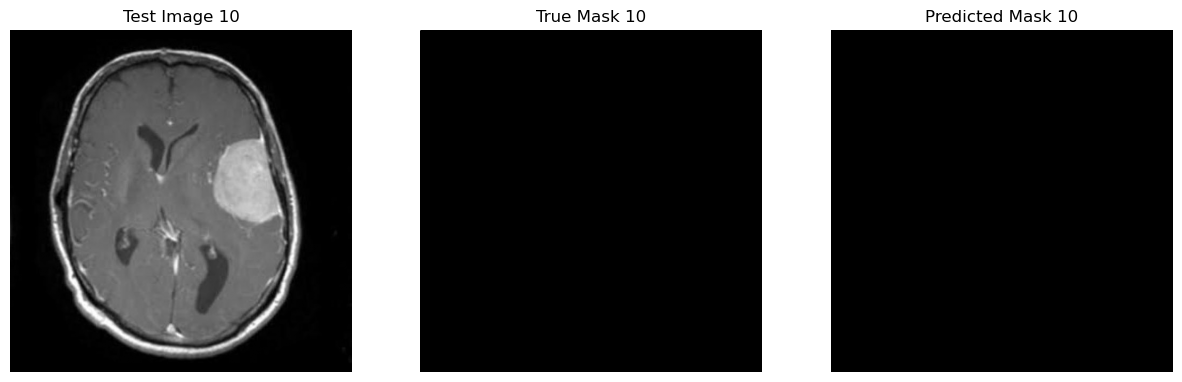

In [75]:
# Example of how to compare a few predicted masks to the ground truth
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the first image and its true mask and predicted mask
axes[0].imshow(test_data[9])
axes[0].set_title('Test Image 10')
axes[1].imshow(test_masks[9], cmap='gray')
axes[1].set_title('True Mask 10')
axes[2].imshow(predicted_masks[9], cmap='gray')
axes[2].set_title('Predicted Mask 10')

for ax in axes:
    ax.axis('off')

plt.show()

In [15]:
#Model accuracy

# Compute pixel-wise accuracy
correct_pixels = np.sum(predicted_masks == test_masks)  # Compare pixel-wise
total_pixels = np.prod(test_masks.shape)  # Total number of pixels

pixel_accuracy = correct_pixels / total_pixels * 100
print(f"Pixel-wise accuracy: {pixel_accuracy:.2f}%")


Pixel-wise accuracy: 100.00%


In [16]:
#Jacqard Index

def calculate_iou(pred_mask, true_mask, num_classes=4):
    ious = []
    
    # Calculate IoU for each class (assuming class labels range from 0 to num_classes-1)
    for i in range(num_classes):
        intersection = np.sum((pred_mask == i) & (true_mask == i))  # Pixels that match
        union = np.sum((pred_mask == i) | (true_mask == i))  # All pixels in either mask
        iou = intersection / union if union != 0 else 0  # Avoid division by zero
        ious.append(iou)
    
    return ious

# Example: Calculate IoU for all test samples
ious = [calculate_iou(pred_mask, true_mask) for pred_mask, true_mask in zip(predicted_masks, test_masks)]

# Calculate average IoU
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.2f}")


Mean IoU: 0.25


In [17]:
#F1 score

def calculate_dice(pred_mask, true_mask, num_classes=4):
    dices = []
    
    # Calculate Dice for each class
    for i in range(num_classes):
        intersection = np.sum((pred_mask == i) & (true_mask == i))
        dice = 2 * intersection / (np.sum(pred_mask == i) + np.sum(true_mask == i)) if (np.sum(pred_mask == i) + np.sum(true_mask == i)) != 0 else 0
        dices.append(dice)
    
    return dices

# Example: Calculate Dice coefficient for all test samples
dices = [calculate_dice(pred_mask, true_mask) for pred_mask, true_mask in zip(predicted_masks, test_masks)]

# Calculate average Dice score
mean_dice = np.mean(dices)
print(f"Mean Dice coefficient: {mean_dice:.2f}")


Mean Dice coefficient: 0.25


In [18]:
#I have a model that isn't performing well. I'll try to improve the model performance by transforming some of the images
#to augment the dataset. 

In [3]:
#Imports
import cv2
import numpy as np
import os
from PIL import Image, ImageEnhance

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import random
from skimage.transform import resize, rotate 
from skimage.exposure import equalize_adapthist

#!pip install albumentations
import albumentations as A
from albumentations.augmentations.geometric.transforms import Affine
from albumentations.core.composition import Compose
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations.geometric.resize import Resize
from tqdm import tqdm

In [4]:

# Define augmentation pipeline
transform = A.Compose([
    A.Resize(256, 256),            # Resize image and mask
    A.RandomRotate90(),            # Rotate image and mask by 90 degrees
    A.HorizontalFlip(),            # Flip image and mask horizontally
    A.Affine(rotate=(-30, 30)),    # Arbitrary rotation between -30 and 30 degrees
])

# Generate the mask from the .txt file
def generate_mask_from_coordinates(txt_file, image_size):
    """Generate a mask based on coordinates from a .txt file."""
    mask = np.zeros(image_size, dtype=np.uint8)  # Initialize a blank mask
    with open(txt_file, 'r') as file:
        for line in file:
            # Parse coordinates, convert to integers
            coords = list(map(float, line.strip().split()))  # Handle floating-point numbers
            if len(coords) >= 4:
                # Convert normalized coordinates to pixel values
                x_min = int(coords[0] * image_size[1])  # Multiply by image width
                y_min = int(coords[1] * image_size[0])  # Multiply by image height
                x_max = int(coords[2] * image_size[1])  # Multiply by image width
                y_max = int(coords[3] * image_size[0])  # Multiply by image height
                # Draw rectangle on mask
                mask[y_min:y_max, x_min:x_max] = 255  # Fill the region with white (255)
    return mask

# Function to load and process images and masks
def process_images_and_masks(images_folder, labels_folder, target_size=(256, 256), apply_transformations=False):
    images = []
    masks = []

    for image_filename in tqdm(sorted(os.listdir(images_folder)), desc="Processing Images"):
        if image_filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_path = os.path.join(images_folder, image_filename)
            label_filename = image_filename.replace('.jpg', '.txt')  # Adjust for your mask format
            label_path = os.path.join(labels_folder, label_filename)

            # Load and resize image
            img = cv2.imread(image_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

            # Load mask (from text file with coordinates)
            if os.path.exists(label_path):
                mask = generate_mask_from_coordinates(label_path, img.shape[:2])
            else:
                continue

            if apply_transformations:
                # Apply transformations
                augmented = transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            else:
                # Resize without transformations
                img = cv2.resize(img, target_size)
                mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Paths
images_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/images"
labels_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/labels"

# Load regular images and masks
regular_images, regular_masks = process_images_and_masks(images_folder, labels_folder, apply_transformations=False)

# Load augmented images and masks
augmented_images, augmented_masks = process_images_and_masks(images_folder, labels_folder, apply_transformations=True)

# Combine regular and augmented data
all_images = np.concatenate([regular_images, augmented_images])
all_masks = np.concatenate([regular_masks, augmented_masks])

# Load unlabeled images
def process_unlabeled_images(images_folder, target_size=(256, 256)):
    unlabeled_images = []
    for image_filename in tqdm(sorted(os.listdir(images_folder)), desc="Processing Unlabeled Images"):
        if image_filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_path = os.path.join(images_folder, image_filename)
            img = cv2.imread(image_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, target_size)
            unlabeled_images.append(img)
    return np.array(unlabeled_images)

unlabeled_folder = "/Users/ofrioren/.cache/kagglehub/datasets/jakeshbohaju/brain-tumor/versions/3/Brain Tumor/Brain Tumor"
unlabeled_images = process_unlabeled_images(unlabeled_folder)

# Final dataset
print(f"Shape of all_images: {all_images.shape}")  # Includes regular + augmented
print(f"Shape of all_masks: {all_masks.shape}")  # Includes regular + augmented masks
print(f"Shape of unlabeled_images: {unlabeled_images.shape}")


Processing Unlabeled Images: 100%|████████| 3762/3762 [00:01<00:00, 3276.38it/s]


Shape of all_images: (204, 256, 256, 3)
Shape of all_masks: (204, 256, 256)
Shape of unlabeled_images: (3762, 256, 256, 3)


In [6]:
#modelling

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

def unet_model(input_shape=(256, 256, 3), num_classes=2):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c5)
    
    model = Model(inputs, outputs)
    return model

# Create the model
model = unet_model(input_shape=(256, 256, 3), num_classes=2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 256, 256,  │      8,224 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     18,464 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_8[0][0]  

 Total params: 466,562 (1.78 MB)

 Trainable params: 466,562 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Ensure the mask values are in the correct range
all_masks[all_masks == 255] = 0  # Fix any out-of-bounds label values

# Compile and train the model again
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

training = model.fit(all_images, all_masks, epochs=3, validation_split=0.2)

Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9013 - loss: 0.2999 - val_accuracy: 1.0000 - val_loss: 0.0413
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 1.0000 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 2.1979e-05
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 1.0000 - loss: 5.2726e-06 - val_accuracy: 1.0000 - val_loss: 2.2449e-11


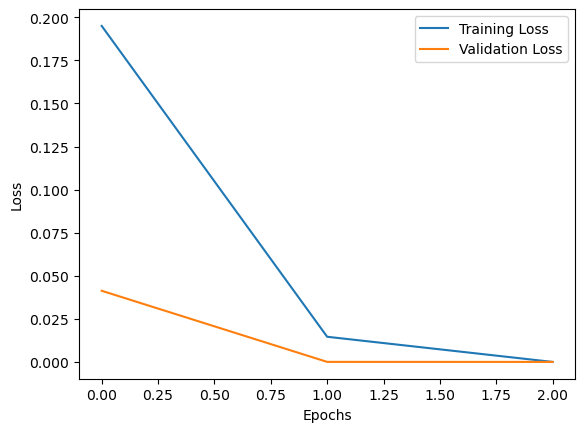

In [17]:
#Generating a checkpoint and saving the node weights
checkpoint = ModelCheckpoint('weights.keras', monitor='val_loss', save_best_only=True)
callbacks = [checkpoint]
print(callbacks)

# Plot the loss and validation loss
plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')

# Add axis labels
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to distinguish the lines
plt.legend()

# Display the plot
plt.show()


In [25]:

# Define augmentation pipeline
transform = A.Compose([
    A.Resize(256, 256),            # Resize image and mask
    A.RandomRotate90(),            # Rotate image and mask by 90 degrees
    A.HorizontalFlip(),            # Flip image and mask horizontally
    A.Affine(rotate=(-30, 30)),    # Arbitrary rotation between -30 and 30 degrees
])

# Generate the mask from the .txt file
def generate_mask_from_coordinates(txt_file, image_size):
    """Generate a mask based on coordinates from a .txt file."""
    mask = np.zeros(image_size, dtype=np.uint8)  # Initialize a blank mask
    with open(txt_file, 'r') as file:
        for line in file:
            # Parse coordinates, convert to integers
            coords = list(map(float, line.strip().split()))  # Handle floating-point numbers
            if len(coords) >= 4:
                # Convert normalized coordinates to pixel values
                x_min = int(coords[0] * image_size[1])  # Multiply by image width
                y_min = int(coords[1] * image_size[0])  # Multiply by image height
                x_max = int(coords[2] * image_size[1])  # Multiply by image width
                y_max = int(coords[3] * image_size[0])  # Multiply by image height
                # Draw rectangle on mask
                mask[y_min:y_max, x_min:x_max] = 255  # Fill the region with white (255)
    return mask

# Function to load and process images and masks
def process_images_and_masks(images_folder, labels_folder, target_size=(256, 256), apply_transformations=False):
    images = []
    masks = []

    for image_filename in tqdm(sorted(os.listdir(images_folder)), desc="Processing Images"):
        if image_filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_path = os.path.join(images_folder, image_filename)
            label_filename = image_filename.replace('.jpg', '.txt')  # Adjust for your mask format
            label_path = os.path.join(labels_folder, label_filename)

            # Load and resize image
            img = cv2.imread(image_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

            # Load mask (from text file with coordinates)
            if os.path.exists(label_path):
                mask = generate_mask_from_coordinates(label_path, img.shape[:2])
            else:
                continue

            if apply_transformations:
                # Apply transformations
                augmented = transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            else:
                # Resize without transformations
                img = cv2.resize(img, target_size)
                mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Paths
images_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/test/images"
labels_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/test/labels"

# Load regular images and masks
test_data, test_masks = process_images_and_masks(images_folder, labels_folder, apply_transformations=False)



Processing Images: 100%|███████████████████████| 15/15 [00:00<00:00, 200.73it/s]


Shape of resized test_data: (15, 256, 256, 3)
Shape of resized test_masks: (15, 256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
Shape of predictions: (15, 256, 256, 2)
Shape of predicted masks: (15, 256, 256)


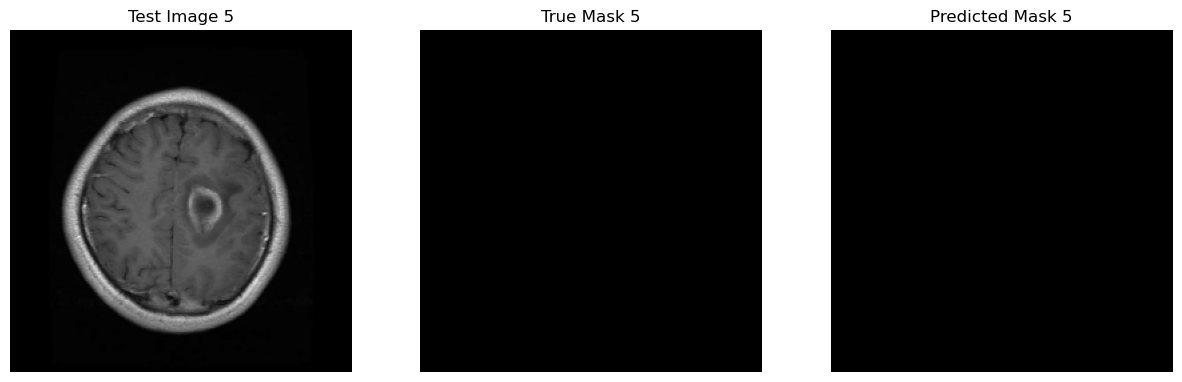

In [27]:
# Function to resize images and masks
def resize_images_and_masks(images, masks, target_size=(256, 256)):
    resized_images = []
    resized_masks = []
    
    for img, mask in zip(images, masks):
        # Resize the image
        img_resized = cv2.resize(img, target_size)
        resized_images.append(img_resized)
        
        # Resize the mask (use nearest neighbor for segmentation masks to preserve label values)
        mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        resized_masks.append(mask_resized)
    
    return np.array(resized_images), np.array(resized_masks)

# Resize the test data and masks to 256x256
test_data_resized, test_masks_resized = resize_images_and_masks(test_data, test_masks, target_size=(256, 256))

# Check the shape after resizing
print(f"Shape of resized test_data: {test_data_resized.shape}")
print(f"Shape of resized test_masks: {test_masks_resized.shape}")

# Predict the output for resized test data (segmentation)
predictions = model.predict(test_data_resized)

# Check the shape of the predictions
print(f"Shape of predictions: {predictions.shape}")

# Predictions will have shape (num_samples, height, width, num_classes)
# Convert predictions to the class with the highest probability for each pixel
predicted_masks = np.argmax(predictions, axis=-1)  # Choose the class with the highest probability per pixel

# Check the shape of predicted masks
print(f"Shape of predicted masks: {predicted_masks.shape}")

# Now, predicted_masks will be the predicted class labels for each pixel in each image
# The shape will be (num_samples, height, width), with each pixel in the mask showing the class id

# Example of how to compare a few predicted masks to the ground truth
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the first image and its true mask and predicted mask
axes[0].imshow(test_data_resized[4])
axes[0].set_title('Test Image 5')
axes[1].imshow(test_masks_resized[4], cmap='gray')
axes[1].set_title('True Mask 5')
axes[2].imshow(predicted_masks[4], cmap='gray')
axes[2].set_title('Predicted Mask 5')

for ax in axes:
    ax.axis('off')

plt.show()


In [29]:
#Model accuracy

# Function to resize images and masks
def resize_images_and_masks(images, masks, target_size=(256, 256)):
    resized_images = []
    resized_masks = []
    
    for img, mask in zip(images, masks):
        # Resize the image
        img_resized = cv2.resize(img, target_size)
        resized_images.append(img_resized)
        
        # Resize the mask (use nearest neighbor for segmentation masks to preserve label values)
        mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        resized_masks.append(mask_resized)
    
    return np.array(resized_images), np.array(resized_masks)

# Resize the test data and masks to 256x256
test_data_resized, test_masks_resized = resize_images_and_masks(test_data, test_masks, target_size=(256, 256))

# Check the shape after resizing
print(f"Shape of resized test_data: {test_data_resized.shape}")
print(f"Shape of resized test_masks: {test_masks_resized.shape}")

# Compute pixel-wise accuracy
def compute_pixel_accuracy(true_masks, predicted_masks):
    # Flatten the masks to 1D arrays for comparison
    true_masks_flat = true_masks.flatten()
    predicted_masks_flat = predicted_masks.flatten()

    # Calculate the number of pixels where true and predicted masks match
    correct_pixels = np.sum(true_masks_flat == predicted_masks_flat)

    # Calculate the total number of pixels
    total_pixels = true_masks_flat.size

    # Compute accuracy
    accuracy = correct_pixels / total_pixels
    return accuracy

# Calculate accuracy on resized test data
accuracy = compute_pixel_accuracy(test_masks_resized, predicted_masks)

print(f"Pixel-wise accuracy: {accuracy * 100:.2f}%")


Shape of resized test_data: (15, 256, 256, 3)
Shape of resized test_masks: (15, 256, 256)
Pixel-wise accuracy: 99.45%


In [31]:
#Jacqard Index

# Resize the test masks to match the predicted masks (256x256)
resized_test_masks = np.array([cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST) for mask in test_masks])

# Modified IoU calculation function
def calculate_iou(pred_mask, true_mask, num_classes=4):
    ious = []
    
    # Calculate IoU for each class (assuming class labels range from 0 to num_classes-1)
    for i in range(num_classes):
        intersection = np.sum((pred_mask == i) & (true_mask == i))  # Pixels that match
        union = np.sum((pred_mask == i) | (true_mask == i))  # All pixels in either mask
        iou = intersection / union if union != 0 else 0  # Avoid division by zero
        ious.append(iou)
    
    return ious

# Example: Calculate IoU for all test samples
ious = [calculate_iou(pred_mask, true_mask) for pred_mask, true_mask in zip(predicted_masks, resized_test_masks)]

# Calculate average IoU
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.2f}")



Mean IoU: 0.25


In [33]:
#I have a model, but it isn't very good. I'll try to see what I can do with more images. 

In [35]:
#!pip install --upgrade kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jakeshbohaju/brain-tumor")

print("Path to dataset files:", path)

Path to dataset files: /Users/ofrioren/.cache/kagglehub/datasets/jakeshbohaju/brain-tumor/versions/3


Loaded image volume shape: (3762, 240, 240, 3)


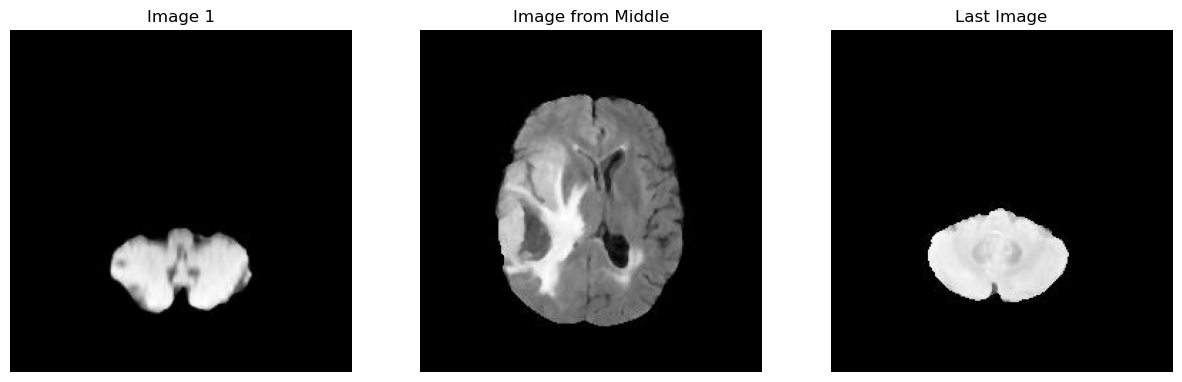

In [37]:
# Path to the folder containing the images
folder_path_images = "/Users/ofrioren/.cache/kagglehub/datasets/jakeshbohaju/brain-tumor/versions/3/Brain Tumor/Brain Tumor"

# Initialize a list to store image data
new_volume_train_images = []

# Iterate through the files in the folder
for filename in sorted(os.listdir(folder_path_images)):  # Sort to maintain order
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Check for valid image files
        filepath_image = os.path.join(folder_path_images, filename)
        try:

            # Open the image using PIL
            img = Image.open(filepath_image).convert('RGB')  # Ensure all images are RGB
            img_array = np.array(img)  # Convert the image to a NumPy array
            new_volume_train_images.append(img_array)  # Append the image to the list
        except Exception as e:
            print(f"Error loading image {filepath_image}: {e}")

# Check if any images were loaded
if new_volume_train_images:
    # Convert the list of images into a NumPy array (volume)
    try:
        new_volume_train_images = np.stack(new_volume_train_images)
        print(f"Loaded image volume shape: {new_volume_train_images.shape}")  # Expected shape: (number_of_images, height, width, channels)
    except ValueError as e:
        print(f"Error stacking images into volume: {e}")

    # Display a few images to confirm successful loading
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    if len(new_volume_train_images) >= 3:
        axes[0].imshow(new_volume_train_images[0])
        axes[0].set_title('Image 1')
        axes[1].imshow(new_volume_train_images[len(new_volume_train_images) // 2])
        axes[1].set_title('Image from Middle')
        axes[2].imshow(new_volume_train_images[-1])
        axes[2].set_title('Last Image')
        for ax in axes:
            ax.axis('off')
        plt.show()
    else:
        print("Not enough images to display.")
else:
    print("No images were loaded. Please check the file path and extensions.")

In [38]:
#Great! I now have 3762 more images to use but unfortunately they do not have masks to identify the location of the tumor
#only a separate csv file that identifies them as having or not having a tumor. I will try to do semi-supervised learning.

In [41]:
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import os

def resize_images(images_folder, target_size=(256, 256)):
    images = []

    for image_filename in sorted(os.listdir(images_folder)):
        if image_filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_path = os.path.join(images_folder, image_filename)
            
            # Load and resize image
            img = Image.open(image_path).convert('RGB')
            img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
            images.append(img_to_array(img_resized))  # Convert to NumPy array

    return np.array(images)

# Set your image folder path
images_folder = "/Users/ofrioren/.cache/kagglehub/datasets/jakeshbohaju/brain-tumor/versions/3/Brain Tumor/Brain Tumor"

# Resize images (no need for masks)
train_data = resize_images(images_folder, target_size=(256, 256))

# Check the shapes
print(f"Shape of train_data: {train_data.shape}")  # Should print: (num_images, 256, 256, 3)


Shape of train_data: (3762, 256, 256, 3)


In [43]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose
from sklearn.metrics import accuracy_score
import random

model = Sequential([
    # Encoding layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Bottleneck layer
    Conv2D(256, (3, 3), activation='relu'),

    # Decoding layers (up-sampling)
    Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu'),
    Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu'),

    # Output layer (1 class for binary segmentation, or more for multi-class)
    Conv2D(1, (1, 1), activation='sigmoid')  # Use 'softmax' for multi-class

])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 57, 57, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 115, 115, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 231, 231, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 231, 231, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,745 (2.96 MB)

 Trainable params: 775,745 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
from cv2 import resize
import numpy as np

# Step 1: Define your unlabeled data (replace this with your actual unlabeled data)
unlabeled_data_filtered = np.random.rand(100, 256, 256, 3)  # Example placeholder, use your real data

# Step 2: Predict pseudo-labels from the model
pseudo_labels = model.predict(unlabeled_data_filtered)  # Model prediction on unlabeled data
print(f"Pseudo labels shape: {pseudo_labels.shape}")  # Debugging info

# Step 3: Filter predictions based on confidence threshold
confident_mask = np.max(pseudo_labels, axis=-1) > 0.9  # Confidence thresholding (e.g., 90%)
print(f"Confidence mask sum: {np.sum(confident_mask)}")  # How many masks passed the threshold?

pseudo_labels_filtered = pseudo_labels[confident_mask]
print(f"Filtered pseudo labels shape: {pseudo_labels_filtered.shape}")  # Debugging info

# Step 4: Convert pseudo_labels_filtered to class indices (assuming it is one-hot encoded)
pseudo_labels_filtered_class = np.argmax(pseudo_labels_filtered, axis=-1)  # Convert to class indices

# Step 5: Resize all pseudo labels to match the target size
valid_masks = []

for i, mask in enumerate(pseudo_labels_filtered_class):
    if mask is not None:
        print(f"Mask {i} shape: {mask.shape}, ndim: {mask.ndim}")  # Debugging info
        if mask.ndim == 2:  # Ensure mask is 2D
            # Ensure the mask is in the correct dtype (uint8) for resizing
            if mask.dtype != np.uint8:
                mask = mask.astype(np.uint8)
            
            # Resize to match target size (256, 256)
            resized_mask = resize(mask, (256, 256))  # Resize using OpenCV
            valid_masks.append(resized_mask)
        else:
            print(f"Skipping mask {i} with incorrect ndim: {mask.ndim}")
    else:
        print(f"Skipping mask {i} because it's None")

# Step 6: Convert the list of resized masks to a NumPy array
if valid_masks:
    pseudo_labels_filtered_class_resized = np.array(valid_masks)
else:
    print("No valid masks found in pseudo_labels_filtered_class.")

# Step 7: Ensure that pseudo_labels_filtered_class_resized has the same shape as train_masks
if 'pseudo_labels_filtered_class_resized' in locals():  # Check if the variable is defined
    if pseudo_labels_filtered_class_resized.shape[1:] != train_masks.shape[1:]:
        # Resize pseudo_labels_filtered_class_resized to match train_masks dimensions
        pseudo_labels_filtered_class_resized = np.array([resize(mask, (train_masks.shape[1], train_masks.shape[2])) for mask in pseudo_labels_filtered_class_resized])

    # Step 8: Now concatenate the labeled data (train_data, train_masks) with the new train data
    new_train_data = np.concatenate([train_data, unlabeled_data_filtered])  # Concatenate images

    # Step 9: Concatenate the corresponding labels (train_masks and pseudo_labels_filtered_class_resized)
    new_train_labels = np.concatenate([train_masks, pseudo_labels_filtered_class_resized])  # Concatenate labels (as class indices)

    # Check the shape of the new combined dataset
    print(f"Shape of new_train_data: {new_train_data.shape}")
    print(f"Shape of new_train_labels: {new_train_labels.shape}")

    # Step 10: Retrain the model with the new dataset
    model.fit(new_train_data, new_train_labels, epochs=10)
else:
    print("Skipping model retraining as no valid pseudo labels were found.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step
Pseudo labels shape: (100, 231, 231, 1)
Confidence mask sum: 0
Filtered pseudo labels shape: (0, 1)
No valid masks found in pseudo_labels_filtered_class.
Skipping model retraining as no valid pseudo labels were found.
